In [1]:
using Pkg
pkg"activate ."
pkg"instantiate"
pkg"precompile"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...


In [2]:
using PerlaTonettiWaugh, Plots, BenchmarkTools, CSV

In [3]:
gr(fmt = :png)

Plots.GRBackend()

# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

Below are the results from the **updated** matlab calibration with the corresponding letters. Here I added the $\mu$ parameter in the calibration routine to fit the firm dynamic moments. Fit improved a lot and it generated a negative drift term which is what we need to keep S from going negative.


In [4]:
changed_parameters = true # set this to true if you drastically change the parameters

true

Side note on previous version. Essentially, under this calibration, the parameters are very simmilar. Theta, chi, kappa are quite close to what we had in the prior version.

In [5]:
# Define common objects. 
parameters = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (transition_penalty_coefficient = 1.0, ))
z_grid = settings.z
P = length(z_grid)

d_0 = 1 + (parameters.d-1).*1.10 # Here is the 10 percent tariff increase
d_T = parameters.d

params_0 = merge(parameters, (d = d_0, )) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T, )) # parameters to be used at t = T

# initial value for numerical solver on (g, z_hat, Omega)
initial_x = [0.02; 2; .57]

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_algebraic(params_0, initial_x) # solution at t = 0
stationary_sol = stationary_algebraic(params_T, initial_x) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

In [6]:
d_0 

3.17283

In [7]:
print(stationary_sol.U_bar(1),'\n') 
print(stationary_sol_0.U_bar(1),'\n')
print(stationary_sol_0.S,'\n')
print(stationary_sol.S,'\n')

40.75846634918868
36.771724154009796
0.11010701157463218
0.11839165909489363


Note that $S$ is now well above zero, not like in the old calibrations. 

## Welfare in Steady States

### Steady state at `T`

In [8]:
stationary_sol.U_bar(1)

40.75846634918868

### Steady state at `0`

In [9]:
stationary_sol_0.U_bar(1)

36.771724154009796

### Outstanding Issue \#1: Sensitivity of growth to trade.

This is a big difference relative to previous version. As noted above, with parameter values that are quite similar to what we had before, the growth rate is changing a lot with only a very small change in trade flows. Why?

In [10]:
@show stationary_sol.g, stationary_sol_0.g;

(stationary_sol.g, stationary_sol_0.g) = (0.020015751789702312, 0.018339070985779814)


---

# Transition dynamics

Setup for optimizer:

In [11]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_numerical(params_T, z_grid), Ω_0 = Ω_0, transition_iterations = 0, T = 75.0));

Use the solution found with calibrated parameters above for `E`

In [48]:
settings = merge(settings, (transition_x0 = zeros(30), transition_lb = -ones(30), transition_ub = zeros(30)));

In [49]:
if changed_parameters # will use the global solver to set a new initial condition, hopefully in the vicinity of the solution implied by the new parameters
    settings = merge(settings, (transition_iterations = 1000,))
    @time result = solve_full_model_global(settings; impose_E_monotonicity_constraints = true)
    E_nodes = result.E_nodes;
    settings = merge(settings, (transition_x0 = E_nodes, ));
end

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
1.21 secs, 2 evals, 1 steps, fitness=0.023262031
2.45 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 1.0000), fitness=0.023262031
4.21 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 0.0000), fitness=0.023262031
5.46 secs, 8 evals, 4 steps, improv/step: 0.250 (last = 0.0000), fitness=0.023262031
6.49 secs, 10 evals, 5 steps, improv/step: 0.200 (last = 0.0000), fitness=0.023262031
7.62 secs, 12 evals, 6 steps, improv/step: 0.333 (last = 1.0000), fitness=0.023262031
8.87 secs, 14 evals, 7 steps, improv/step: 0.286 (last = 0.0000), fitness=0.023262031
9.97 secs, 16 evals, 8 steps, improv/step: 0.375 (last = 1.0000), fitness=0.023262031
11.56 secs, 18 evals, 9 steps, improv/step: 0.444 (last = 1.0000), fitness=0.0232620

(z_max = 5, z = [0.0, 0.000250627, 0.000501253, 0.00075188, 0.00100251, 0.00125313, 0.00150376, 0.00175439, 0.00200501, 0.00225564  …  4.63636, 4.67677, 4.71717, 4.75758, 4.79798, 4.83838, 4.87879, 4.91919, 4.9596, 5.0], Δ_E = 1.0e-6, ode_solve_algorithm = Sundials.CVODE_BDF{:Newton,:Dense}(0, 0, 0, 0, false, 10, 5, 7, 3, 10), T = 75.0, t = 0.0:4.444444444444445:40.0, g = 10-element extrapolate(scale(interpolate(::Array{Float64,1}, BSpline(Interpolations.Linear())), (0.0:4.444444444444445:40.0,)), Throw()) with element type Float64:
 0.020309375466592776
 0.06475381991103722 
 0.10919826435548166 
 0.15364270879992611 
 0.19808715324437057 
 0.242531597688815   
 0.28697604213325945 
 0.3314204865777039  
 0.37586493102214835 
 0.4203093754665928  , entry_residuals_nodes_count = 30, transition_x0 = [-0.991363, -0.960659, -0.90433, -0.855, -0.785671, -0.699855, -0.613614, -0.450466, -0.209864, -0.191966  …  -0.0438747, -0.0419461, -0.0271277, -0.025505, -0.0217126, -0.0153737, -0.013425

Find the corresponding solution

In [50]:
settings.transition_x0

30-element Array{Float64,1}:
 -0.9913628565947209   
 -0.9606594574941437   
 -0.9043304489730931   
 -0.8549996366407646   
 -0.7856713044226733   
 -0.6998547694336763   
 -0.6136139399816029   
 -0.4504661472886451   
 -0.20986403038223264  
 -0.19196581015477565  
 -0.19024255119714034  
 -0.17462468679291834  
 -0.1407512094682176   
  ⋮                    
 -0.07077435980806851  
 -0.06254911167081247  
 -0.043874735343005795 
 -0.04194608008791498  
 -0.027127745158455008 
 -0.0255050268279821   
 -0.021712648236922663 
 -0.015373725314280023 
 -0.013425582508009582 
 -0.004334481589620675 
 -0.0032566610494434173
 -0.002892990131959372 

In [51]:
@time result = solve_full_model(settings; impose_E_monotonicity_constraints = true, write_csv = true, csvpath = "somecsv.csv")
solved = result.solution;
E_nodes = result.E_nodes;
solved = solved.results;

107.895617 seconds (169.48 M allocations: 242.866 GiB, 40.12% gc time)


---
## Welfare Gains

In [52]:
print("Utility in initial SS: ", stationary_sol_0.U_bar(1),"\n")
print("Utility in new SS: ", stationary_sol.U_bar(1),"\n")

Utility in initial SS: 36.771724154009796
Utility in new SS: 40.75846634918868


In [53]:
print("Utility immediately after change ", solved.U[1],"\n")

Utility immediately after change 57.14850011517548


#### Summary so far...

In the old paper, what we did was take U_0_ss at some date t, then compare it to U_ss at the same date t. This is like an instentanous jump to the new ss. This is what the first cell is looking at and note that this is like a 17 percent increase in utility. Higher than what we had in the paper, but in of the same order of magnitude. 

The next cell reprots the utility just after the change. Utility here includes the future path of consumption and change in growth rate, so it "bakes in" the transition path. Here it goes up by much more than utility in the new SS. This is what I was expecting given the dynamics of consumption. 

Just a reminder about how the function `counsumption_equivalent(U_new, U_old, parameters)` works, it takes U_new and then U_old in that order, then evaluates the **gross** increase in consumption. 100 times this value **minus one** gives the permanent, percent increase in consumption required to make the agent indifferent between the two paths. 

In [54]:
T = solved.t[end]
lambda_ss = 100*(consumption_equivalent(stationary_sol.U_bar(0), stationary_sol_0.U_bar(0), parameters)-1)

print("SS to SS welfare gain: ", lambda_ss,"\n")

SS to SS welfare gain: 8.118554194374417


In [55]:
lambda_tpath = 100*(consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(0), parameters)-1)

print("Inclusive of the Transition Path: ", lambda_tpath,"\n")

Inclusive of the Transition Path: 53.09287696369216


### Relative to initial notebook computations

- SS to SS, the issue here is that we should compare **at date 0** utility in the first ss vs. the second ss. This is what we must have been doing in the previous version of the paper. The previous calulation in the old notebook had 
```consumption_equivalent(solved.U[end], stationary_sol_0.U_bar(T), parameters)```
which took **date T** utility and compard them. The problem is that this now depends on date T. So if we picked T to be arbitraily large, then utility will be arbitraily different.

- Following the same logic, the transition path should compare **date 0** utility with the initial value from the transition path. So what we want to do is to compare everything at 0. In the previous calculation, we had
```consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(T), parameters)```
were comparing the initial utility relative to ss utility on the old path at date T. So the initial blue point below versues the last orange dashed point. **See the figure below**

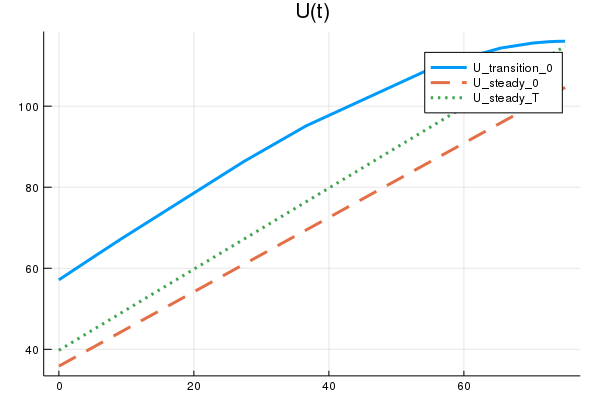

In [56]:
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

### Outstanding Issue \#2: Welfare Gains still depend on T in transition path.

The stuff above I think is correct, the one issue is why does the welfare gains, inclusive of the transition path seem to depend on T??? So change T above from 40 to 75 or 100, then the welfare gains fall alot? Why?

---
## Plotting

In [57]:
solved.U[end]

116.020846553842

## Plots for Ω and residuals

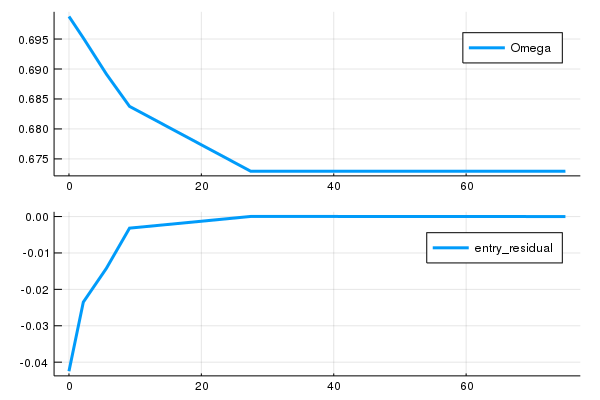

In [58]:
#solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

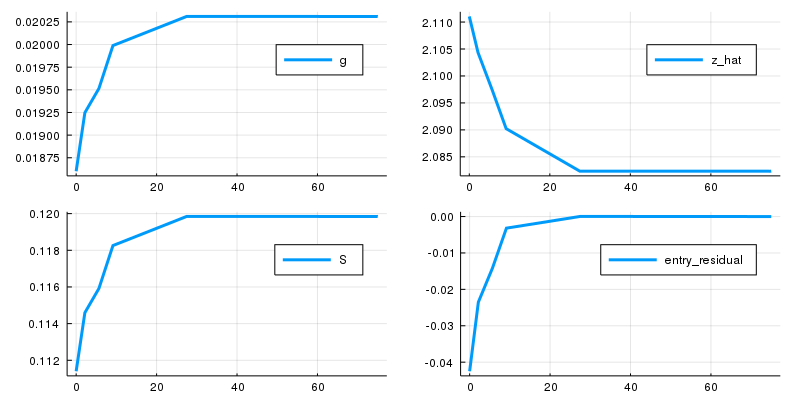

In [59]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

## Static Equations

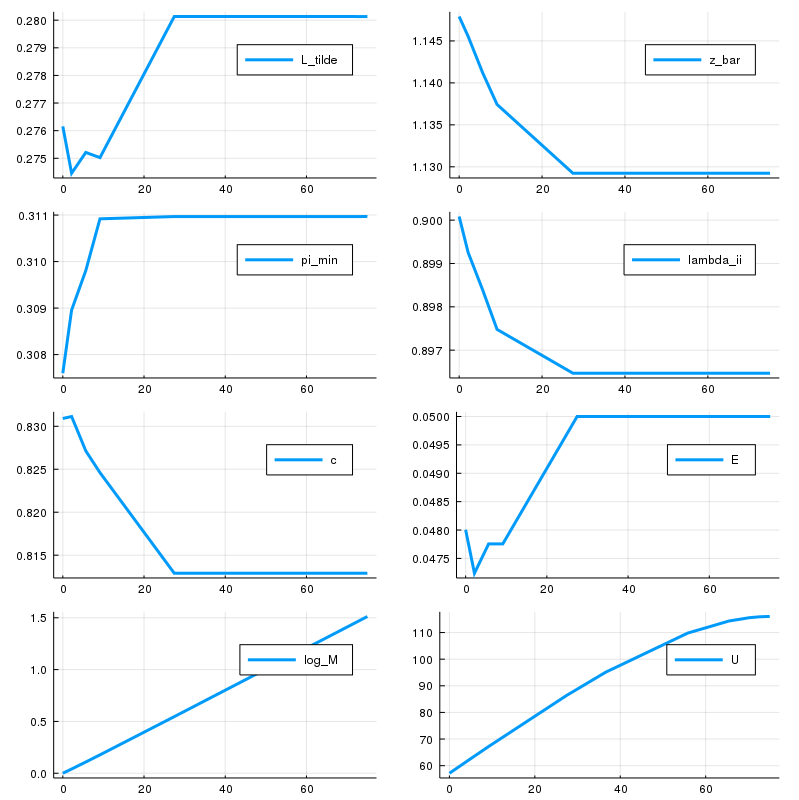

In [60]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2), size = (800, 800))

# Welfare analysis

### `log_M(t)`

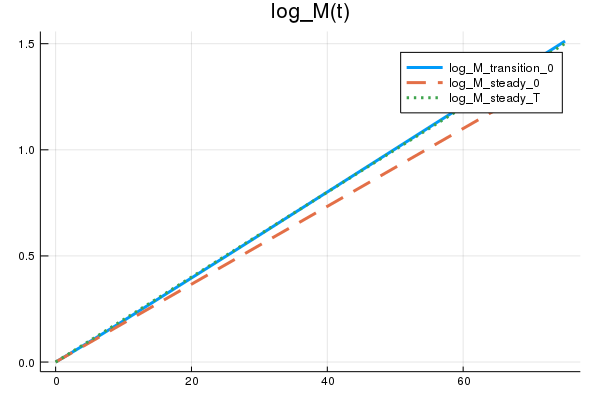

In [61]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

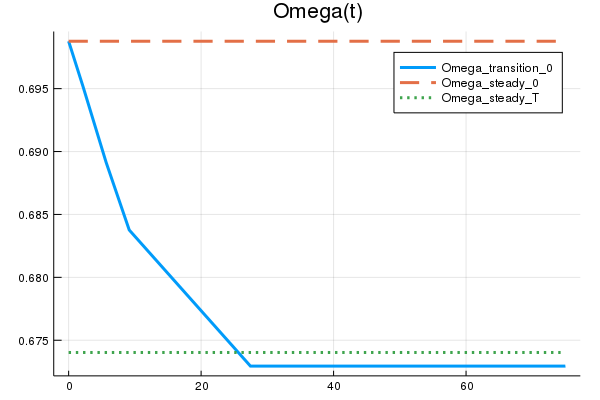

In [62]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

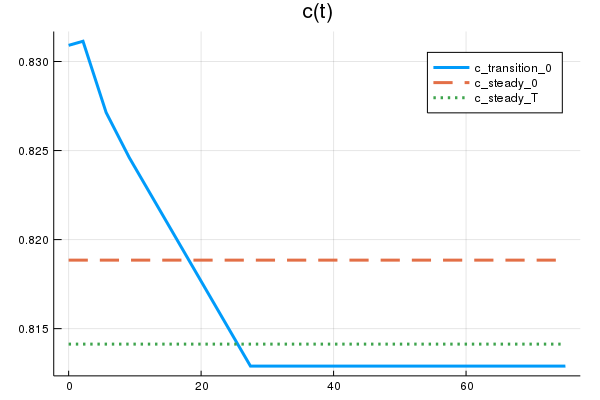

In [63]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

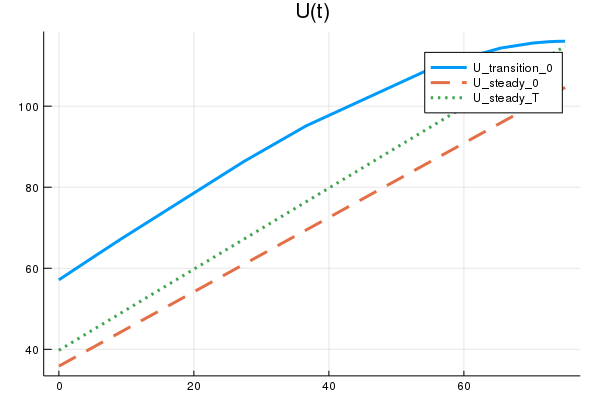

In [64]:
# generate the plot!
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [65]:
T = solved.t[end]
consumption_equivalent(solved.U[end], stationary_sol_0.U_bar(T), parameters)

1.2559486645648046

### `M(0)` by autarky and transition from `t=0`

In [66]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(T), parameters)

0.3869128776202943

But if we include the transition path, this falls a lot. Like down to 13 percent gain. 

In [67]:
stationary_sol.U_bar(90)/stationary_sol.U_bar(89)

1.0077684148120571

In [68]:
# solved 
# Run the above to see the whole dataframe

In [69]:
using DataFrames

df_stationary = DataFrame(t = -1.00, g =stationary_sol_0.g, λ_ii = stationary_sol_0.λ_ii, c = stationary_sol_0.c, L_tilde = stationary_sol_0.L_tilde, Ω = stationary_sol_0.Ω);

In [34]:
CSV.write("stationary_results.csv", df_stationary)

"stationary_results.csv"